## MBA em Ciência de Dados
# Redes Neurais e Aprendizado Profundo

## <span style="color:darkred">Avaliação Final - 2024 : Enuncaido</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `imdb-reviews-pt-br.csv` que contém avaliações de filmes realizadas no site IMDB, com textos em português e em inglês. O alvo do dataset é a coluna `sentiment` que contém o sentimento relacionado à avaliação: positivo ou negativo.

Vamos explorar um sentence embedding pré-treinado para multiplos idiomas, e avaliar redes neurais comparando-as com relação aos textos em inglês e português.

As tarefas a realizar são as seguintes:

Preparação:
1. **Instalar o pacote** `sentence_transformers` e **carregar o modelo** 'stsb-xlm-r-multilingual' para geração de sentence embeddings, conforme mostrado no código abaixo.
2. **Carregar a base de dados** e obter uma amostra de 12 mil linhas (use o método `sample` do dataframe pandas).
3. **Gerar os embeddings** usando o método encode, para os textos em português e em inglês. Ver https://www.sbert.net/examples/applications/computing-embeddings/README.html para mais detalhes. OBS: pode demorar um pouco
4. **Separar dados** 75% para treinamento, 25% para teste usando `train_test_split`, sendo a mesma partição para ingles e portugues.

Modelos:
1.  (1,0 pt) **Modelo A**: projete e treine uma rede neural profunda densa, utilizando como entrada os embeddings pré-treinados dos dados em **portugues** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * normalização em batch
        * densa 768 neurônios, relu
        * densa 512 neurônios, relu
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar Adam com taxa de aprendizado inicial de 0.0007 e com decaimento em todas as épocas exponencial a -0.09
    * Treinar com perda entropia cruzada por 15 épocas com batch size 20
    * Compute como métricas, além da perda, a área sob a curva ROC (AUC ROC) e a Acurácia Binária (ver https://www.tensorflow.org/api_docs/python/tf/keras/metrics)<br><br>

2.  (1,0 pt) **Modelo B**: projete e treine uma rede neural profunda densa, utilizando como entrada os *textos tokenizados* em **português** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * camada embedding com max_words=5000 e dimensão do embedding de tamanho 386
        * camada convolucional 1d com 64 neuronios de tamanho 2 e padding='same', ativação relu
        * camada LSTM 512 neurônios, sem especificar ativação (manter a default)
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar os mesmos hiper-parâmetros de otimização, treinamento e métricas do modelo anterior<br><br>


3. (2,0 pt) **Avalie as rede neurais de classificação** (Modelos A e B):
    * Exiba o gráfico das métricas ROC AUC e Accuracy calculadas no treinamento ao longo das épocas para o modelos A e B
    * Calcule e exiba as métricas no conjunto de teste usando o cada modelo</br>
    3.1 (2,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

4. (3,0 pt) **Fine-tuning** dos Modelo B com os dados em inglês, treinando por 15 épocas e batch_size=20, com Adam e taxa de aprendizado 0.00001 (sem decaimento):
    1. Modelo Fine Tuning versão 1: realize ajuste fino, congelando a camada de embeddings,
    2. Modelo Fine Tuning versão 2: realize ajuste fino, congelando a camada convolucional e a camada LSTM.
        
    * exibir a função de custo ao longo das épocas de treinamento para cada modelo,
    * calcular e exibir métricas dos modelos após fine-tuning usando o conjunto de teste em ingles (textos tokenizados)</br>
    4.1 (1,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

5. **Bônus:** (+1 ponto extra)
    * *Análise visual das características*: visualize scatterplots com os 2 dimensões obtidos com o método tSNE as classes dos exemplos atribuídas com cores ou marcadores diferentes:
        1. scatterplot com projeção tSNE do conjunto de teste referente ao embedding pré-treinado em português,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste tokenizado em português referente ao *Modelo B*,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste em inglês (tokens) referente ao *Modelo B* após ajuste fino versão 2.
    * Escreva comentários com suas conclusões sobre a análise visual.

## Preparação

### 1. Carregar bibliotecas e modelo pré-treinado SentenceTransformer

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from numpy.random import seed

from tensorflow.random import set_seed
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#### Verifique a versão do Tensorflow, recomendamos a 2.17.
OBS: o código pode ter problemas com a versão 2.18

In [2]:
print(tf.__version__)

2.17.1


In [3]:
# baixar modelo codificador de setenças
model = SentenceTransformer('stsb-xlm-r-multilingual')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 2. Carregar base de dados e obter amostra

In [4]:
!gdown 1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK

# ler base de dados
df_orig = pd.read_csv("imdb-reviews-pt-br.csv", delimiter=',', engine='python')

Downloading...
From (original): https://drive.google.com/uc?id=1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK
From (redirected): https://drive.google.com/uc?id=1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK&confirm=t&uuid=0e3e3045-525a-4f8d-b55e-3b13dc3e4e91
To: /content/imdb-reviews-pt-br.csv
100% 127M/127M [00:01<00:00, 127MB/s]


In [5]:
df_orig.describe()

,id
count,49459.000000
mean,24730.960917
std,14277.792868
min,1.000000
25%,12366.500000
50%,24731.000000
75%,37095.500000
max,49460.000000


In [6]:
# obter amostra
df = df_orig.sample(12000).reset_index(drop=True)
df.sentiment.value_counts()

,count
sentiment,
neg,6008
pos,5992


### 3. Separar dados em treinamento e teste e preparar rótulos

Iremos também verificar o tamanho das strings em cada instancia, para considerar apenas um número de caracteres proporcional ao percentil 80.

In [7]:
# rotulos
y = np.array((df.sentiment=='pos').astype(int))

X_train_txt_en, X_test_txt_en, y_train_en, y_test_en= train_test_split(df.text_en.values, y, test_size=0.25, random_state=51)
X_train_txt_pt, X_test_txt_pt, y_train_pt, y_test_pt= train_test_split(df.text_pt.values, y, test_size=0.25, random_state=51)

sum(y_train_en!=y_train_pt)

0

In [8]:
# tamanhos das strings - usaremos o percentil 80 como tamanho da entrada máximo
num_words = df.text_pt.apply(lambda x: len(str(x).split()))
max_length = num_words.max()
percentile_80 = num_words.quantile(0.80)
percentile_95 = num_words.quantile(0.95)

print(f"percentil 80.0: {percentile_80}")
print(f"percentil 95.0: {percentile_95}")
print(f"Maximo: {max_length}")

percentil 80.0: 308.0
percentil 95.0: 546.0
Maximo: 955


### 4. Geração dos embeddings

Utilizar o encoder carregado para obter os embeddings para treinamento e teste em Português e Inglês, separadamente.

Exemplo de uso: `model.encode(texto, batch_size=16, show_progress_bar=True)`

In [9]:
#X_train_en = model.encode(X_train_txt_en, batch_size=16, show_progress_bar=True)
# ...
# Obter embeddings para textos em inglês (treinamento e teste)
X_train_en_embeddings = model.encode(X_train_txt_en, batch_size=16, show_progress_bar=True)
X_test_en_embeddings = model.encode(X_test_txt_en, batch_size=16, show_progress_bar=True)

# Obter embeddings para textos em português (treinamento e teste)
X_train_pt_embeddings = model.encode(X_train_txt_pt, batch_size=16, show_progress_bar=True)
X_test_pt_embeddings = model.encode(X_test_txt_pt, batch_size=16, show_progress_bar=True)

# Exibindo as dimensões dos embeddings gerados
print("Dimensões dos embeddings gerados:")
print(f"X_train_en_embeddings: {X_train_en_embeddings.shape}")
print(f"X_test_en_embeddings: {X_test_en_embeddings.shape}")
print(f"X_train_pt_embeddings: {X_train_pt_embeddings.shape}")
print(f"X_test_pt_embeddings: {X_test_pt_embeddings.shape}")

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Dimensões dos embeddings gerados:
X_train_en_embeddings: (9000, 768)
X_test_en_embeddings: (3000, 768)
X_train_pt_embeddings: (9000, 768)
X_test_pt_embeddings: (3000, 768)


5. Tokenização do texto

Definiremos um número máximo de palavras e um tamanho máximo de sequência com base nos dados em Português, conforme abaixo.

In [10]:
max_words = 5000  # Numero maximo de palavras
max_sequence_length = int(percentile_80)  # Tamanho maximo da sequencia igual ao percentil 80

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_txt_pt)

sequences_train = tokenizer.texts_to_sequences(X_train_txt_pt)
sequences_test = tokenizer.texts_to_sequences(X_test_txt_pt)

# realizar padding para igualar sentencas
X_train_tok_pt = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_tok_pt = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [11]:
## realizar o mesmo procedimento para os textos em ingles
# use os mesmos parametros de maximo de palavras e sequencia
max_words = 5000  # Numero maximo de palavras
max_sequence_length = int(percentile_80)  # Tamanho maximo da sequencia igual ao percentil 80

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_txt_en)

sequences_train = tokenizer.texts_to_sequences(X_train_txt_en)
sequences_test = tokenizer.texts_to_sequences(X_test_txt_en)

# realizar padding para igualar sentencas
X_train_tok_en = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_tok_en = pad_sequences(sequences_test, maxlen=max_sequence_length)

---

## Tarefas

Definimos os modelos e iniciamos as tarefas. O código abaixo é uma referência para auxiliar na resolução, complete/altere conforme necessário.

In [12]:
# DICA: use keras.layers.CAMADA para montar as arquiteturas

# definir modelo A
def model_A(input_dim):
    input_data = keras.layers.Input(shape=(input_dim,))
    # ...
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    dnn = keras.models.Model(input_data, output)
    return dnn

In [13]:
# definir modelo B
def model_B(input_dim, max_words, embedding_dim=386, code_dim=256):
    input_layer = keras.layers.Input(shape=(input_dim,))
    embedding_layer = keras.layers.Embedding(max_words, embedding_dim, name='embedding')(input_layer)
    # ...
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [14]:
epochs = 15
batch_size = 20
lrate = 0.0007

---

### 1. (1,0 pt) Modelo A: classificador de sentimento em *portugues* usando embedding pré-treinado

In [15]:
#seed(1)
#set_seed(2)

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.09))

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# instanciar, compilar e treinar modelo A

np.random.seed(1)
tf.random.set_seed(2)

# Definir modelo A
def model_A(input_dim):
    input_data = keras.layers.Input(shape=(input_dim,))

    # Camada de normalização em batch
    x = keras.layers.BatchNormalization()(input_data)

    # Camada densa 1: 768 neurônios, ativação ReLU
    x = keras.layers.Dense(768, activation='relu')(x)

    # Camada densa 2: 512 neurônios, ativação ReLU
    x = keras.layers.Dense(512, activation='relu')(x)

    # Camada densa intermediária: 256 neurônios, ativação linear
    x = keras.layers.Dense(256, activation='linear')(x)

    # Normalização em batch
    x = keras.layers.BatchNormalization()(x)

    # Ativação ReLU
    x = keras.layers.Activation('relu')(x)

    # Dropout
    x = keras.layers.Dropout(0.375)(x)

    # Camada de saída: 1 neurônio, ativação sigmoide
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    # Criar o modelo
    dnn = keras.models.Model(input_data, output)
    return dnn

# Inicializar modelo com dimensão de entrada
input_dim = X_train_pt_embeddings.shape[1]
modelA = model_A(input_dim)

# Compilar modelo
initial_lr = 0.0007
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
modelA.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
)

# Treinar o modelo
historyA = modelA.fit(
    X_train_pt_embeddings, y_train_pt,
    validation_data=(X_test_pt_embeddings, y_test_pt),
    epochs=15,
    batch_size=20,
    callbacks=[callbacklr]
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7161 - auc: 0.7891 - loss: 0.5852 - val_accuracy: 0.7860 - val_auc: 0.8726 - val_loss: 0.4593 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7809 - auc: 0.8620 - loss: 0.4644 - val_accuracy: 0.7893 - val_auc: 0.8722 - val_loss: 0.4613 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - auc: 0.8918 - loss: 0.4165 - val_accuracy: 0.7790 - val_auc: 0.8682 - val_loss: 0.4911 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8408 - auc: 0.9216 - loss: 0.3574 - val_accuracy: 0.7790 - val_auc: 0.8671 - val_loss: 0.5211 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8800 - auc: 0.9511 - loss: 0.2843 - val_accuracy: 0.7733 - val_auc: 0.8569 - val_loss: 0.6305 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

---

### 2. (1,0 pt) Modelo B: classificador de sentimento em *português* usando tokenizador e rede CNN+LSTM

In [16]:
#seed(1)
#set_seed(2)

# instanciar, compilar e treinar modelo B

# Definir as seeds para reprodutibilidade
np.random.seed(1)
tf.random.set_seed(2)

# Definir modelo B
def model_B(max_words, embedding_dim=386):
    input_layer = keras.layers.Input(shape=(None,))

    # Camada de embedding
    embedding_layer = keras.layers.Embedding(max_words, embedding_dim, name='embedding')(input_layer)

    # Camada convolucional 1D
    conv1d_layer = keras.layers.Conv1D(64, kernel_size=2, padding='same', activation='relu')(embedding_layer)

    # Camada LSTM
    lstm_layer = keras.layers.LSTM(512)(conv1d_layer)

    # Camada densa intermediária
    dense_layer = keras.layers.Dense(256, activation='linear')(lstm_layer)

    # Normalização em batch
    batch_norm_layer = keras.layers.BatchNormalization()(dense_layer)

    # Ativação ReLU
    relu_activation = keras.layers.Activation('relu')(batch_norm_layer)

    # Dropout
    dropout_layer = keras.layers.Dropout(0.375)(relu_activation)

    # Camada de saída
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

    # Criar o modelo
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Inicializar o modelo
max_words = 5000
embedding_dim = 386
#input_dim = 305 Testando por conta de erro
modelB = model_B(max_words, embedding_dim)

# Compilar o modelo
initial_lr = 0.0007
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
modelB.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
)

# Definir o scheduler para ajuste de taxa de aprendizado
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.09))

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)



In [17]:
# Treinar o modelo
historyB = modelB.fit(
    X_train_tok_pt, y_train_pt,
    validation_data=(X_test_tok_pt, y_test_pt),
    epochs=15,
    batch_size=20,
    callbacks=[callbacklr]
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.6377 - auc: 0.6959 - loss: 0.6246 - val_accuracy: 0.6420 - val_auc: 0.8986 - val_loss: 0.5890 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8037 - auc: 0.8868 - loss: 0.4218 - val_accuracy: 0.4900 - val_auc: 0.5000 - val_loss: 13.7849 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9125 - auc: 0.9707 - loss: 0.2192 - val_accuracy: 0.4900 - val_auc: 0.5000 - val_loss: 32.1604 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9642 - auc: 0.9934 - loss: 0.1022 - val_accuracy: 0.5100 - val_auc: 0.5000 - val_loss: 34.9080 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9808 - auc: 0.9977 - loss: 0.0595 - val_accuracy: 0.5100 - val_auc: 0.5000 - val_loss: 43.3458 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46

---

### 3. (2,0 pt) Avaliação dos modelos: métricas durante treinamento e avaliação das métricas no conjunto de teste de ambos os modelos

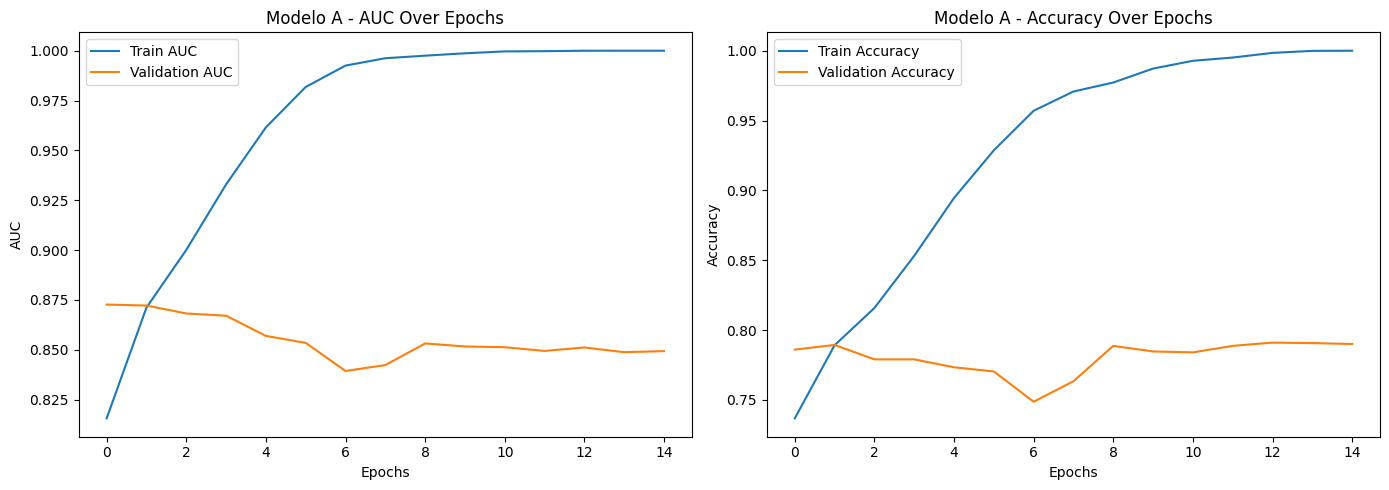

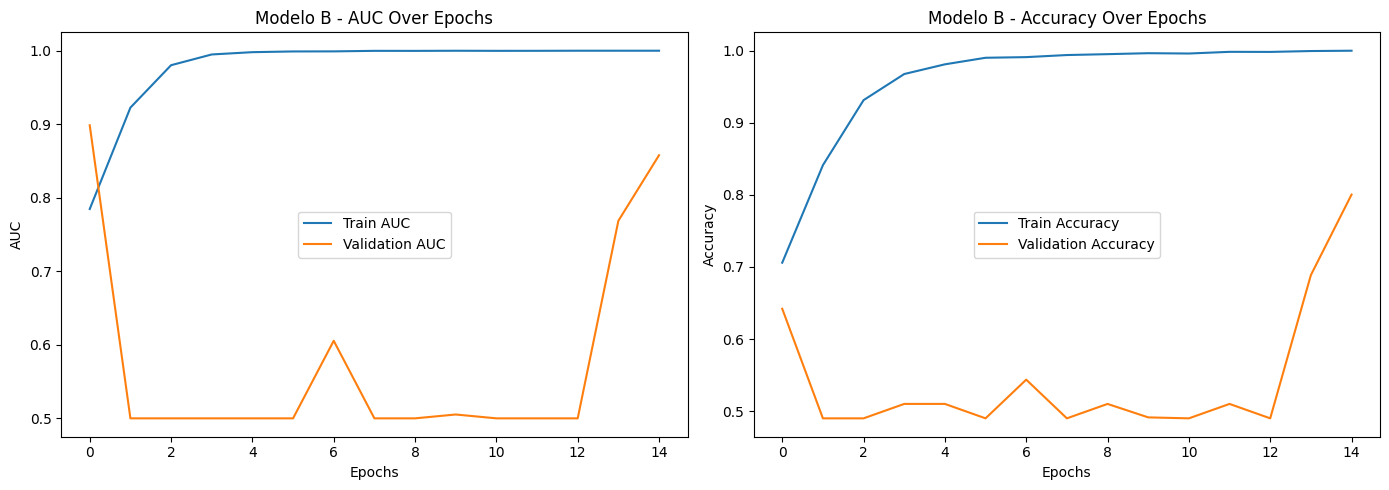

In [18]:
## plot métricas durante treinamento dos modelos A e B
# Função para exibir gráficos de métricas durante o treinamento
def plot_training_metrics(history, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 5))

    # Plotar AUC
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f'{model_name} - AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    # Plotar Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exibir métricas de treinamento para os Modelos A e B
plot_training_metrics(historyA, "Modelo A")
plot_training_metrics(historyB, "Modelo B")


In [19]:
## avaliacao no conjunto de teste dos modelos A e B treinados
# exibir os valores obtidos
# Função para calcular métricas no conjunto de teste
def evaluate_model(model, X_test, y_test, model_name):
    from sklearn.metrics import roc_auc_score, accuracy_score

    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))

    print(f"{model_name} - Test Set Metrics:")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return auc, accuracy

# Avaliar os modelos no conjunto de teste
auc_a, acc_a = evaluate_model(modelA, X_test_pt_embeddings, y_test_pt, "Modelo A")
auc_b, acc_b = evaluate_model(modelB, X_test_tok_pt, y_test_pt, "Modelo B")

# Comparação dos resultados
results = {
    "Modelo": ["Modelo A", "Modelo B"],
    "Test ROC AUC": [auc_a, auc_b],
    "Test Accuracy": [acc_a, acc_b]
}

results_df = pd.DataFrame(results)
print(results_df)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Modelo A - Test Set Metrics:
ROC AUC: 0.8681
Accuracy: 0.7900
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Modelo B - Test Set Metrics:
ROC AUC: 0.9081
Accuracy: 0.8003
     Modelo  Test ROC AUC  Test Accuracy
0  Modelo A      0.868073       0.790000
1  Modelo B      0.908137       0.800333


### 3.1 (2,0 pt) Escreva conclusões sobre a comparação entre os modelos A e B em termos:
- das métricas computadas ao longo do treinamento
- conclua sobre os resultados da generalização dos modelos e relacione esse resultado com a arquitetura de cada modelo (camadas utilizadas e número de parâmetros).

Escreva apenas um parágrafo para cada um dos items acima. As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook.

< suas conclusões aqui >

<div class="alert alert-block alert-info">
    <p><b>Métricas de treinamento:</b></p>
    <p></p>
    <p>O modelo A apresentou um desempenho melhor em termos de AUC e acurácia durante o treinamento, tanto nos dados de treinamento quanto nos de validação. As métricas de validação do modelo A se mantiveram mais "estáveis" ao longo das épocas, enquanto o modelo B apresentou maior variação, com algumas quedas significativas na acurácia. Apesar da boa performance geral do modelo A, é importante notar a diferença entre as métricas de treino e validação, o que pode indicar um pouco de overfitting. No gráfico de AUC dá a impressão inclusive dos valores de validação estarem caindo suavemente ao longo das épocas. O modelo B, por sua vez, apresentou uma tendência mais clara de overfitting, com uma diferença maior entre as métricas de treino e validação que praticamente sempre apresentam valores baixos.</p>
    <p></p>
    <p><b>Generalização e arquitetura:</b></p>
    <p></p>
    <p>Embora o modelo B tenha alcançado resultados competitivos em umas 3 épocas (aparentemente aleatórias pois quando se executa novamente o código a variação desses valores muda bastante), a instabilidade e o fato das métricas de validação serem quase todas baixas mostram uma menor capacidade de generalização em comparação ao modelo A. Essa diferença pode ser explicada pela arquitetura dos modelos. O modelo A, que utiliza embeddings pré-treinados como entrada para uma rede densa, se beneficia da capacidade de generalização dos embeddings e da simplicidade da rede.  Já o modelo B, com sua estrutura mais complexa de CNN+LSTM e tokenização, pode estar mais suscetível ao overfitting, especialmente considerando o tamanho relativamente pequeno do conjunto de dados. Vale ressaltar que o modelo B possui um número significativamente maior de parâmetros treináveis, o que também pode contribuir para o overfitting. </p>
    <p></p>
    <p>Em resumo, o modelo A demonstrou melhor generalização e um desempenho mais consistente durante o treinamento, apesar disso, há indícios de um pouco de overfitting. A estrutura mais simples e o uso de embeddings pré-treinados parecem ter contribuído para esses resultados. O modelo B, por outro lado, apresentou um overfitting mais pronunciado, possivelmente devido à sua maior complexidade e ao número de parâmetros treináveis. Os dois modelos poderiam ser trabalhados para melhorar a generalização, seja por meio de regularização, aumento de dados ou ajustes na arquitetura.</p>
</div>

---

### 4. (3,0 pt) Fine-tuning do Modelo B usando os dados em **ingles**

O modelo foi treinado com dados em português e agora queremos realizar transferência de aprendizado, realizando ajuste fino dos parâmetros para que possa classificar texto em inglês.

Serão feitos dois experimentos, ambos a partir dos pesos do modelo B, usando os tokens extraídos dos textos em ingles:

1. Modelo B FT v1: congele a camada de embedding (ou seja setando essa camada como `trainable=False`), e permita que todas as demais possam se adaptar.
2. Modelo B FT v2: congele apenas a camada convolucional e a camada LSTM, e permita que todas as demais (inclusive a camada de embedding, anterior a essas) possam se adaptar.

Após o treinamento compare ambos modelos exibindo:
- um gráfico com a loss ao longo do treinamento
- um gráfico com as métricas obtidas ao longo do treinamento
- as métricas (numéricas) obtidas no conjunto de teste

In [20]:
## Experimentos de Fine-tuning do Modelo B
from tensorflow.keras.models import clone_model

# Função para criar o modelo com pesos congelados
def create_finetune_model(base_model, trainable_layers):
    # Clonar o modelo base para preservar os pesos
    new_model = clone_model(base_model)
    new_model.set_weights(base_model.get_weights())

    # Congelar/descongelar camadas conforme o experimento
    for layer in new_model.layers:
        layer.trainable = layer.name in trainable_layers

    # Compilar o modelo ajustado com learning rate fixo
    new_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00001),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.BinaryAccuracy(name="accuracy")]
    )
    return new_model


In [21]:
# Cria novo modelo copiando a arquitetura e pesos anteriores
# ajusta camadas a serem treinadas ou congeladas
# realizar finetuning com learning rate fixo = 0.00001
# Experimento 1: Modelo B FT v1
trainable_layers_v1 = {"conv1d", "lstm", "dense", "batch_normalization", "activation", "dropout", "dense_1"}
modelB_FT_v1 = create_finetune_model(modelB, trainable_layers_v1)

# Experimento 2: Modelo B FT v2
trainable_layers_v2 = {"embedding", "dense", "batch_normalization", "activation", "dropout", "dense_1"}
modelB_FT_v2 = create_finetune_model(modelB, trainable_layers_v2)

# Ajuste fino no Modelo B FT v1
history_FT_v1 = modelB_FT_v1.fit(
    X_train_tok_en, y_train_en,  # Tokens e rótulos em inglês
    validation_data=(X_test_tok_en, y_test_en),
    epochs=15,
    batch_size=20
)

# Ajuste fino no Modelo B FT v2
history_FT_v2 = modelB_FT_v2.fit(
    X_train_tok_en, y_train_en,  # Tokens e rótulos em inglês
    validation_data=(X_test_tok_en, y_test_en),
    epochs=15,
    batch_size=20
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5031 - auc: 0.4949 - loss: 3.1094 - val_accuracy: 0.4947 - val_auc: 0.4879 - val_loss: 1.2667
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4990 - auc: 0.4984 - loss: 1.0844 - val_accuracy: 0.5007 - val_auc: 0.4906 - val_loss: 0.8498
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5065 - auc: 0.5052 - loss: 0.8070 - val_accuracy: 0.4997 - val_auc: 0.4929 - val_loss: 0.7540
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.5060 - auc: 0.5070 - loss: 0.7347 - val_accuracy: 0.5030 - val_auc: 0.4961 - val_loss: 0.7232
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5025 - auc: 0.5040 - loss: 0.7141 - val_accuracy: 0.5057 - val_auc: 0.4988 - val_loss: 0.7104
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5115 - auc: 0.5090 - loss: 0.7033 - val_accuracy: 0.5023 - val_auc: 0.5011 - val_loss: 0.7042
Epoch 7/15
450/450 ━━━━━━━━━

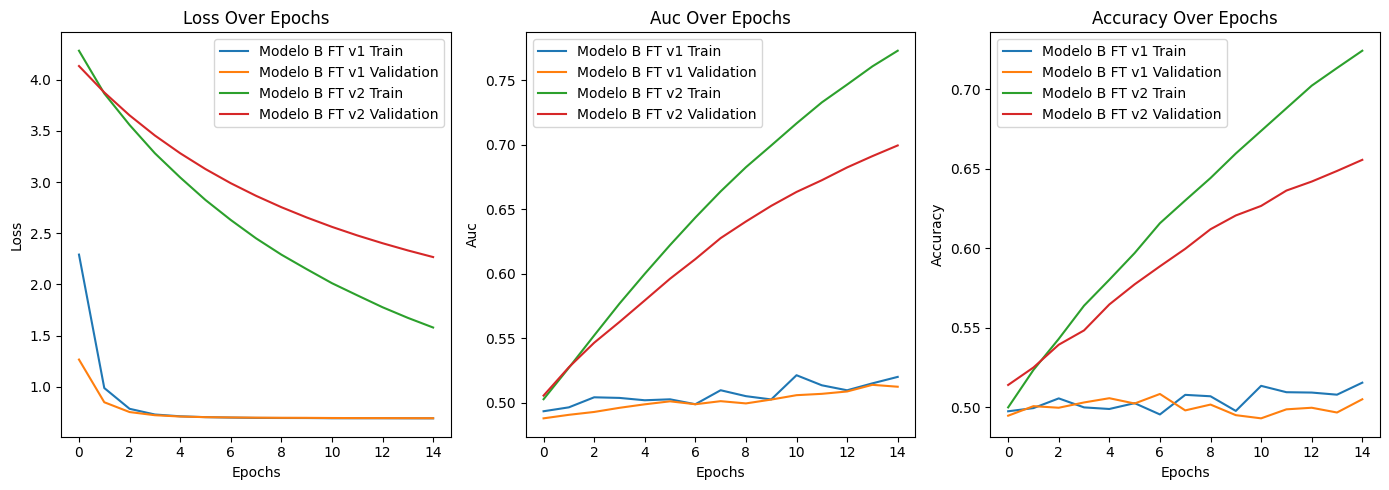

In [22]:
# visualiza loss de treinamento dos modelos

# Função para plotar métricas
import matplotlib.pyplot as plt
def plot_metrics(histories, metrics, labels):
    plt.figure(figsize=(14, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        for history, label in zip(histories, labels):
            plt.plot(history.history[metric], label=f'{label} Train')
            plt.plot(history.history[f'val_{metric}'], label=f'{label} Validation')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

# Plotar gráficos de loss e métricas
plot_metrics(
    histories=[history_FT_v1, history_FT_v2],
    metrics=['loss', 'auc', 'accuracy'],
    labels=['Modelo B FT v1', 'Modelo B FT v2']
)

In [23]:
# visualiza métricas de treinamento dos modelos
# Avaliar os modelos no conjunto de teste
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))
    print(f"{model_name} - Test Set Metrics:")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return auc, accuracy

# Avaliar os modelos
print("\nAvaliação dos Modelos no Conjunto de Teste:")
auc_v1, acc_v1 = evaluate_model(modelB_FT_v1, X_test_tok_en, y_test_en, "Modelo B FT v1")
auc_v2, acc_v2 = evaluate_model(modelB_FT_v2, X_test_tok_en, y_test_en, "Modelo B FT v2")


Avaliação dos Modelos no Conjunto de Teste:
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Modelo B FT v1 - Test Set Metrics:
ROC AUC: 0.5149
Accuracy: 0.5050
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Modelo B FT v2 - Test Set Metrics:
ROC AUC: 0.7120
Accuracy: 0.6557


In [24]:
# avaliacao e comparacao com dados de teste
# Comparação de métricas
results = {
    "Modelo": ["Modelo B FT v1", "Modelo B FT v2"],
    "Test ROC AUC": [auc_v1, auc_v2],
    "Test Accuracy": [acc_v1, acc_v2]
}

results_df = pd.DataFrame(results)
print("\nComparação de Desempenho:")
print(results_df)


Comparação de Desempenho:
           Modelo  Test ROC AUC  Test Accuracy
0  Modelo B FT v1      0.514919       0.505000
1  Modelo B FT v2      0.711987       0.655667


#### 5.1 (1,0 pt) Conclusões sobre o Fine-tuning realizado

Conclua sobre o fine-tuning realizado, comparando os dois modelos abordando:
- a loss e métricas computadas ao longo do treinamento para cada modelo
- as métricas obtidas com os dados de teste
- compare os modelos em termos de sua capacidade de generalização, indicando as razões de terem generalizado melhor ou pior.

As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook. Escreva um ou dois parágrafos com suas conclusões.

_< suas conclusões >_
<div class="alert alert-block alert-info">
    <p><b>Métricas de Treinamento:</b></p>
<p></p>
<p>V1 (azul e laranja): A loss do modelo V1 cai inicialmente, mas depois se estabiliza. A queda brusca pode ser sinal de overfitting. As métricas de AUC e acurácia também mostram um desempenho ruim, com valores baixos e pouca melhora ao longo das épocas. Isso e o fato do gráfico de perda estabilizar no início (ideal seria uma queda mais constante, mesmo que suave) indica que o modelo V1 tem dificuldades para aprender os padrões dos dados em inglês.</p>
    <p>V2 (verde e vermelho): O modelo V2 apresenta uma queda consistente na loss ao longo das épocas, convergindo para um valor baixo. A AUC e a acurácia aumentam progressivamente, demonstrando que o modelo está aprendendo efetivamente com os dados em inglês.</p>
    <p></p>
    <p><b>Métricas de Teste e Generalização:</b></p>
<p></p>
<p>De acordo com os resultados e observação dos gráficos, podemos inferir, com base no desempenho durante o treinamento, que o modelo V2 provavelmente terá melhor desempenho que o V1 em dados futuros. Isso se deve à sua capacidade de generalização, que parece ser superior.</p>
<p></p>
<p><b>Comparação e Razões:</b></p>
<p></p>
<p>A diferença principal entre os modelos está na camada de embedding. No V1, ela permanece congelada, o que impede o modelo de se adaptar às particularidades do inglês. Em contraste, no V2, a camada de embedding é treinável, permitindo que o modelo ajuste seus pesos e aprenda representações mais adequadas para outro idioma. Essa flexibilidade do V2 contribui para sua melhor capacidade de generalização e, consequentemente, para um desempenho superior no fine-tuning.</p>
<p></p>
<p>Sei que não é parte da questão mas me chamou a atenção o fato de usar o learning rate fixo em 0.00001. A impressão é que o "incremento" é muito pequeno. Tentei fazer alguns testes mantendo o LR fixo para ver os resultados, aumentando por exemplo o número de epochs e também alterando o LR para um valor mais alto (0.0001) ou váriável como no caso dos modelos A e B. Confesso que não consegui otimizar como achei que poderia, mas ficou nítida a importância do parâmetro no treinamento. Com um LR mais alto, por exemplo, mantendo as 15 epochs, consegui aumentar a acurácia do modelo mais rapidamente, mas entendo os riscos em contrapartida, podendo perder a convergência por exemplo.</p>
</div>

---
## Bônus (+1pt)

### Análise visual e conclusões

A partir dos espaços de características dos dados de teste usando tSNE em duas dimensões:

a. Espaço embedding original dos dados de teste em portugues,<br>
b. Espaço embedding Modelo B dos dados de teste em português,<br>
c. Espaço embedding Modelo B ajustado para inglês (segunda versão do finetuning) dos dados de teste em ingles.

Tarefas:
1. Plote os espaços projetados em 2D pelo TNSE usando os parametros definidos no exemplo abaixo. Utilize cores e/ou formatos de pontos no gráfico de forma a diferenciar os pontos de cada classe.

2. Escreva um parágrafo com conclusões sobre essa análise visual do espaço embedding/características aprendidas. As conclusões tem que fazer sentido com os plots exibidos.

_<suas conclusões>_

<div class="alert alert-block alert-info">
    <p><b>Análise visual do embedding:</b></p>
    <p>Professor vou ser muito sincero. Tentei muito mas não consegui. Ou talvez tenha conseguido, mas não compreendi o suficiente para interpretar corretamente. Tive dificuldade em saber qual camada escolher para representar. Percebi que com a escolha que fiz, que o modelo B parece visualmente, separar/classificar melhor que o V2. Eu esperava o contrário, já que o modelo B não performou bem durante o treinamento e o V2 foi o que fez isso melhor. Não sei se estou interpretando erroneamente o gráfico (Já que o modelo B parece separar mais os casos positivos e negativos), não sei se a minha execução da atividade bônus está errada ou se eventualmente errei todo o treinamento dos modelos B e V2. Estava mais seguro até tentar essa atividade.
    </p>
</div>

In [25]:
from sklearn.manifold import TSNE

#parametros TSNE
#TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Função para plotar os espaços projetados em 2D com t-SNE
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6, random_state=42)
    features_2d = tsne.fit_transform(features)

    # Codificando as labels para usar cores diferentes
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    unique_classes = le.classes_

    # Plotando
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_classes):
        idx = encoded_labels == i
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=label, alpha=0.7)

    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()



In [26]:
modelB.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 386)           │       1,930,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 64)            │          49,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,880,309 (37.69 MB)

 Trainable params: 3,293,265 (12.56 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,586,532 (25.13 MB)

In [27]:
modelB_FT_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_9 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 386)           │       1,930,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 64)            │          49,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,153,779 (27.29 MB)

 Trainable params: 1,930,000 (7.36 MB)

 Non-trainable params: 1,363,777 (5.20 MB)

 Optimizer params: 3,860,002 (14.72 MB)

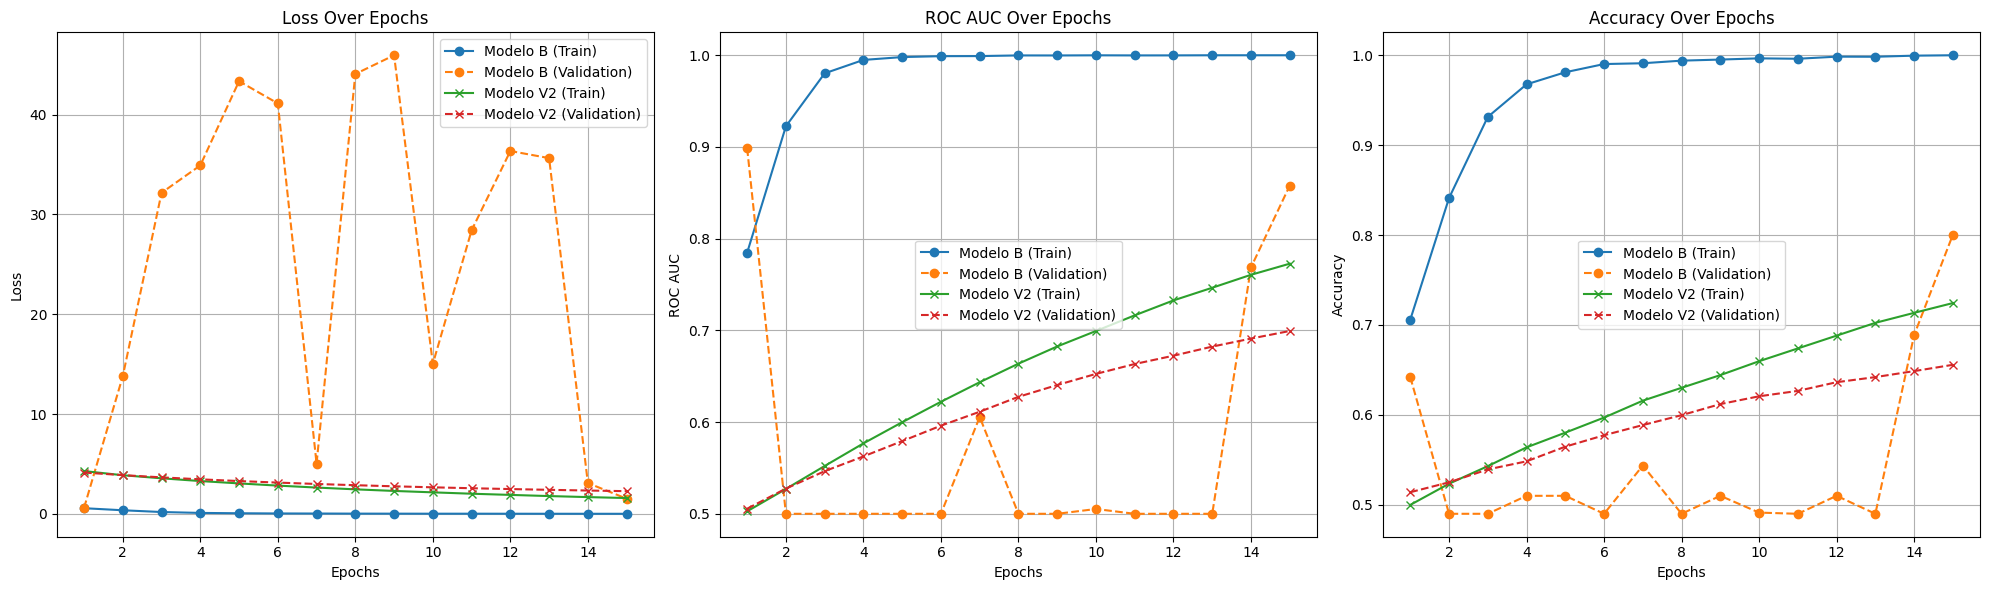

In [28]:
import matplotlib.pyplot as plt

# Extrair os dados reais do histórico do treinamento
history_B = historyB.history
history_V2 = history_FT_v2.history

epochs = range(1, len(history_B['loss']) + 1)  # Número de épocas

# Gráficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loss over Epochs
axes[0].plot(epochs, history_B['loss'], label="Modelo B (Train)", marker='o')
axes[0].plot(epochs, history_B['val_loss'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[0].plot(epochs, history_V2['loss'], label="Modelo V2 (Train)", marker='x')
axes[0].plot(epochs, history_V2['val_loss'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ROC AUC over Epochs
axes[1].plot(epochs, history_B['auc'], label="Modelo B (Train)", marker='o')
axes[1].plot(epochs, history_B['val_auc'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[1].plot(epochs, history_V2['auc'], label="Modelo V2 (Train)", marker='x')
axes[1].plot(epochs, history_V2['val_auc'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[1].set_title("ROC AUC Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("ROC AUC")
axes[1].legend()
axes[1].grid(True)

# Accuracy over Epochs
axes[2].plot(epochs, history_B['accuracy'], label="Modelo B (Train)", marker='o')
axes[2].plot(epochs, history_B['val_accuracy'], label="Modelo B (Validation)", marker='o', linestyle='dashed')
axes[2].plot(epochs, history_V2['accuracy'], label="Modelo V2 (Train)", marker='x')
axes[2].plot(epochs, history_V2['val_accuracy'], label="Modelo V2 (Validation)", marker='x', linestyle='dashed')
axes[2].set_title("Accuracy Over Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Accuracy")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


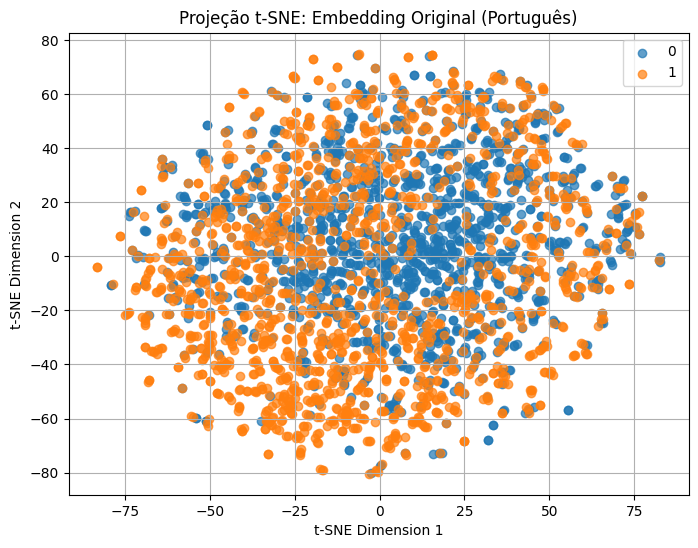

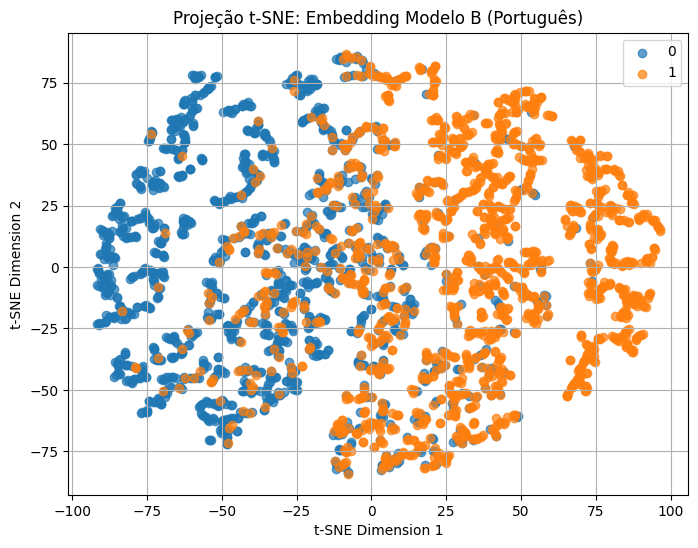

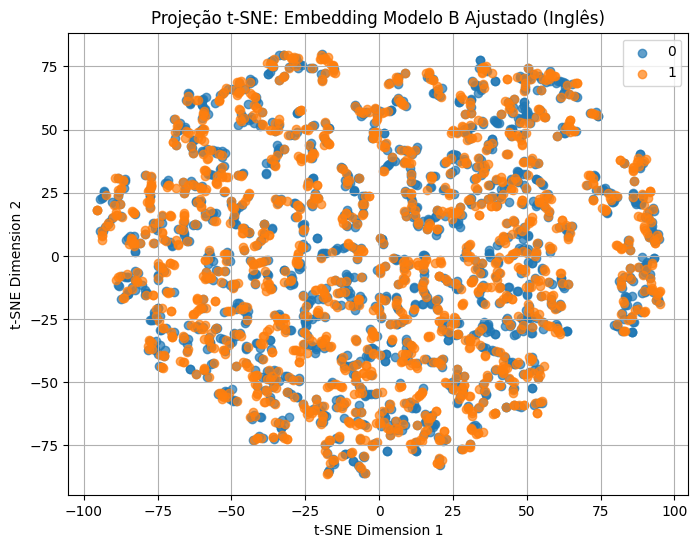

In [29]:
# plot dos espaços em 2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Plotar os embeddings originais (português)
layer_name = 'dense_4'

# Criar um modelo que retorna a saída da camada desejada
embedding_model = Model(inputs=modelB.input, outputs=modelB.get_layer(layer_name).output)

# Passe os dados de teste para extrair os embeddings
X_test_pt_embeddings_B = embedding_model.predict(X_test_tok_pt)


# Criar um modelo que retorna a saída da camada desejada
embedding_model_V2 = Model(inputs=modelB_FT_v2.input, outputs=modelB_FT_v2.get_layer(layer_name).output)

# Passe os dados de teste para extrair os embeddings
X_test_en_embeddings_B = embedding_model.predict(X_test_tok_en)


scaler = StandardScaler()
X_test_pt_embeddings_B_2d_normalized = scaler.fit_transform(X_test_pt_embeddings_B)
X_test_en_embeddings_B_2d_normalized = scaler.fit_transform(X_test_en_embeddings_B)

# Plotando os gráficos
plot_tsne(X_test_pt_embeddings, y_test_pt, "Projeção t-SNE: Embedding Original (Português)")
plot_tsne(X_test_pt_embeddings_B_2d_normalized, y_test_pt, "Projeção t-SNE: Embedding Modelo B (Português)")
plot_tsne(X_test_en_embeddings_B_2d_normalized, y_test_en, "Projeção t-SNE: Embedding Modelo B Ajustado (Inglês)")
